# Kruger ML
## Gregory Glatzer | The Pennsylvania State University

The purpose of this notebook is to attempt to apply machine learning techniques to the dataset of 14 elephant's movement data in Kruger National Park in South Africa.

In [1]:
!pip install scikit-learn
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import geopandas as gpd
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from pyproj import CRS
from shapely.geometry import Point
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

## Load data

In [2]:
def load_movebank_data(study_name, epsg=3395):
    # Default epsg:3395 (Mercator)
    
    # Define parts of filepaths
    root_folder = r"C:\Users\grego\Anti-Poaching Research\data\Movebank"
    study_data = study_name + ".csv"
    reference_data = study_name + "-reference-data.csv"
    
    
    # build filepaths
    study_fp = os.path.join(root_folder, study_name, study_data)
    reference_fp = os.path.join(root_folder, study_name, reference_data)

    
    # load data
    study_df = pd.read_csv(study_fp)
    reference_df = pd.read_csv(reference_fp)
    
    # Create shapely Points
    study_df["geometry"] = study_df.apply(lambda row: Point([row["location-long"], row["location-lat"]]), axis=1)
    
    # Create gdf and assign CRS
    study_gdf = gpd.GeoDataFrame(study_df, geometry="geometry")
    study_gdf.crs = CRS(f"epsg:{epsg}").to_wkt()
    
    # cast timestamp to dt
    study_gdf["timestamp"] = pd.to_datetime(study_gdf["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
    
    
    return study_gdf, reference_df

In [3]:
data, reference = load_movebank_data("ThermochronTracking Elephants Kruger 2007", epsg=22293)
data.head()

event-id  visible           timestamp  location-long  location-lat  \
0  9421351127     True 2007-08-13 00:30:00       31.87091     -24.81373   
1  9421351128     True 2007-08-13 02:00:00       31.87399     -24.81483   
2  9421351129     True 2007-08-13 03:31:00       31.87724     -24.81673   
3  9421351130     True 2007-08-13 04:00:00       31.87822     -24.81569   
4  9421351131     True 2007-08-13 06:00:00       31.89554     -24.79870   

   external-temperature sensor-type individual-taxon-canonical-name  \
0                  24.0         gps              Loxodonta africana   
1                  23.0         gps              Loxodonta africana   
2                  21.0         gps              Loxodonta africana   
3                  21.0         gps              Loxodonta africana   
4                  22.0         gps              Loxodonta africana   

  tag-local-identifier individual-local-identifier  \
0                AM105                       AM105   
1                AM105                       AM105   
2                AM105                       AM105   
3                AM105                       AM105   
4                AM105                       AM105   

                                  study-name                    geometry  
0  ThermochronTracking Elephants Kruger 2007  POINT (31.87091 -24.81373)  
1  ThermochronTracking Elephants Kruger 2007  POINT (31.87399 -24.81483)  
2  ThermochronTracking Elephants Kruger 2007  POINT (31.87724 -24.81673)  
3  ThermochronTracking Elephants Kruger 2007  POINT (31.87822 -24.81569)  
4  ThermochronTracking Elephants Kruger 2007  POINT (31.89554 -24.79870)

## Apply DBSCAN
DBSCAN is an unsupervised clustering algorithm that tends to perform well on spatial data. I found that including the `external-temperature` column in the data used to fit DBSCAN improved its ability to identify clusters, even when the final visualization did not concern the `external-temperature` variable. 

**Hyperparameters**

I tested various combinations of the `eps` and `min_samples` hyperparameters of DBSCAN and found eps = 0.1 or 0.2 and min_samples = 50 or 35 to perform best. The different use cases are described below.

In [4]:
#### Helper functions

def perform_DBSCAN(data, radius, min_points, noise, cols):

    subset = data[cols]
    scaled = StandardScaler().fit_transform(subset)

    # perform DBSCAN 
    db = DBSCAN(eps=radius, min_samples=min_points).fit(scaled)
    
    # add cluster labels
    labels = db.labels_
    data["cluster"] = labels
    
    if not noise:
        return data[data["cluster"] != -1]

    return data
    

def get_clusters(data, cols, r = 0.2, mp = 50, noise=False):
    """
    calls perform_DBSCAN and calculates centroids
    noise: return the datapoints that are not in any clusters (aka noise)
    """

    # Apply DBSCAN
    clusters = perform_DBSCAN(data, 
                              radius=r, 
                              min_points=mp,
                              noise=noise,
                              cols=cols
                             )

    # calculate centroids
    centroids = clusters.groupby("cluster").apply(np.mean)
    centroids["geometry"] = centroids.apply(lambda row: Point([row["location-long"], row["location-lat"]]), axis=1)

    
    return clusters, centroids

In [7]:
def plot_centroids(centroids, ax, hue="cluster"):
    centroids_heat = centroids[centroids["feature space"] == "Temp-influenced"]
    sns.scatterplot(data = centroids_heat, 
                        x="location-long", 
                        y="location-lat",
                        color="black",
                        palette="Paired",
                        marker="X",
                        s=85,
                        legend=False,
                        ax=ax
                       )
    
    # I am aware that the style attribute won't be used since I split up the data.
    # It is solely to render the legend for the different marker shapes
    centroids_wo = centroids[centroids["feature space"] == "Without temp-influence"]
    sns.scatterplot(data = centroids_wo, 
                        x="location-long", 
                        y="location-lat",
                        hue=hue,
                        palette="Paired",
                        style="feature space",
                        style_order=["Without temp-influence", "Temp-influenced"],
                        s=75,
                        edgecolor='black',
                        linewidth=.8,
                        ax=ax
                       )


def plot_range(clusters, centroids, id):
    """
    plots clusters and centroids for ONE elephant
    """
    
    # plot clusters
    fig, ax = plt.subplots(1, figsize=(10,10))
    sns.set_style("white")
    sns.despine()
    sns.scatterplot(data = clusters, 
                    x="location-long", 
                    y="location-lat",
                    hue="cluster",
                    palette="Paired",
                    legend=False,
                    s=4,
                    ax=ax
                   )
    
    plot_centroids(centroids, ax)
    

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Legend")
    plt.title(f"Clustering {id} movement with DBSCAN", fontsize=18)
    plt.show()

### How does temperature affect the clustering?

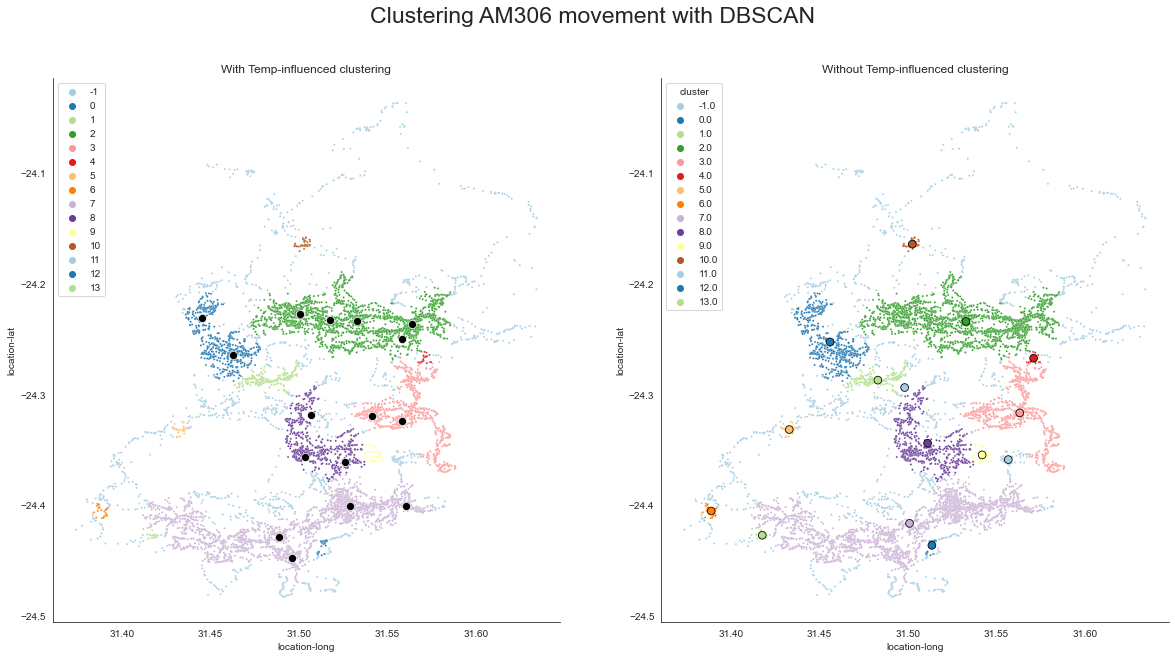

In [8]:
group = data[data["tag-local-identifier"] == "AM306"]

def with_and_without_heat(data, noise=True):
    r=0.2
    mp=50
    clusters_heat, centroids_heat = get_clusters(data, 
                                           ["location-long", "location-lat", "external-temperature"],
                                           r=r, mp=mp, 
                                           noise=noise
                                          )
    centroids_heat["feature space"] = "Temp-influenced"


    r=0.1
    mp=35
    clusters_wo, centroids_wo = get_clusters(data, 
                                           ["location-long", "location-lat"],
                                           r=r, mp=mp, 
                                           noise=noise
                                          )
    centroids_wo["feature space"] = "Without temp-influence"
    
    return [(clusters_heat, centroids_heat), (clusters_wo, centroids_wo)]


(clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(group)

# plot with heat
fig, axs = plt.subplots(1,2, figsize=(20,10))
sns.set_style("white")
sns.despine()
sns.scatterplot(data = clusters_heat, 
                x="location-long", 
                y="location-lat",
                hue="cluster",
                palette="Paired",
                s=4,
                ax=axs[0]
               )
sns.scatterplot(data = centroids_heat, 
                    x="location-long", 
                    y="location-lat",
                    marker="o",
                    color="black",
                    s=65,
                    ax=axs[0]
                   )


# plot without heat
sns.scatterplot(data = clusters_wo, 
                x="location-long", 
                y="location-lat",
                hue="cluster",
                palette="Paired",
                legend=False,
                s=4,
                ax=axs[1]
               )
sns.scatterplot(data = centroids_wo, 
                    x="location-long", 
                    y="location-lat",
                    hue="cluster",
                    palette="Paired",
                    marker="o",
                    s=60,
                    edgecolor='black',
                    linewidth=.8,
                    ax=axs[1]
                   )

fig.suptitle("Clustering AM306 movement with DBSCAN", fontsize=23)
axs[0].set_title("With Temp-influenced clustering")
axs[1].set_title("Without Temp-influenced clustering")
plt.show()

It appears that the temperature feature accounts for some of the clustering found (visually) in the map. For example, the center-right area of the dark pink area is identified as a cluster on the temp-influenced map, however it is not on the map that relies solely on location data for clustering. However, There also seems to clusters that are only identified when temperature is omitted as a clustering feature. Thus, to account for both kinds of centroids, we should calculate both with and without heat and combine, as seen below.

You may have noticed that the hyperparameters are different for the two maps. The different setups performed better with different parameterizations.

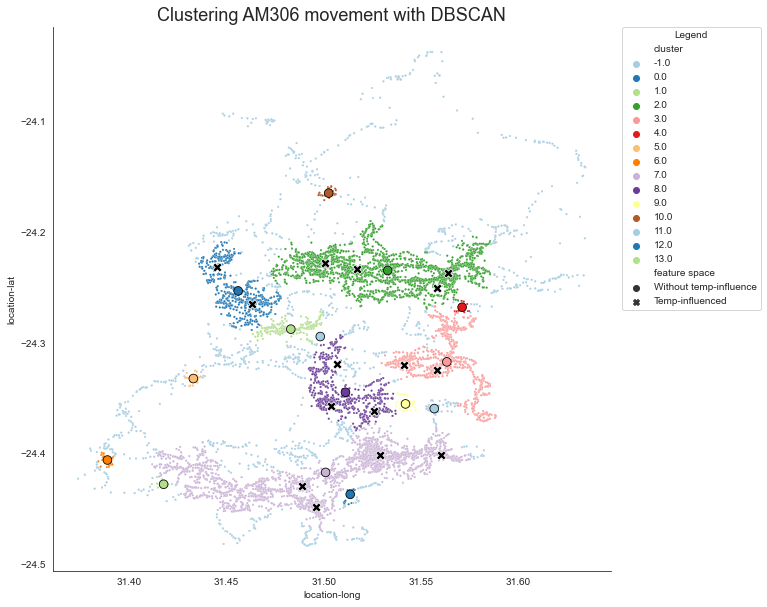

In [9]:
## Final algorithm

group = data[data["tag-local-identifier"] == "AM306"]


(clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(group)

clusters = clusters_heat.append(clusters_wo)
centroids = centroids_heat.append(centroids_wo)

plot_range(clusters, centroids, "AM306")

Now that we have determined a sufficient way to calculate and display clusters and centroids, let's apply it to the entire dataset.

### Individual range cluster maps

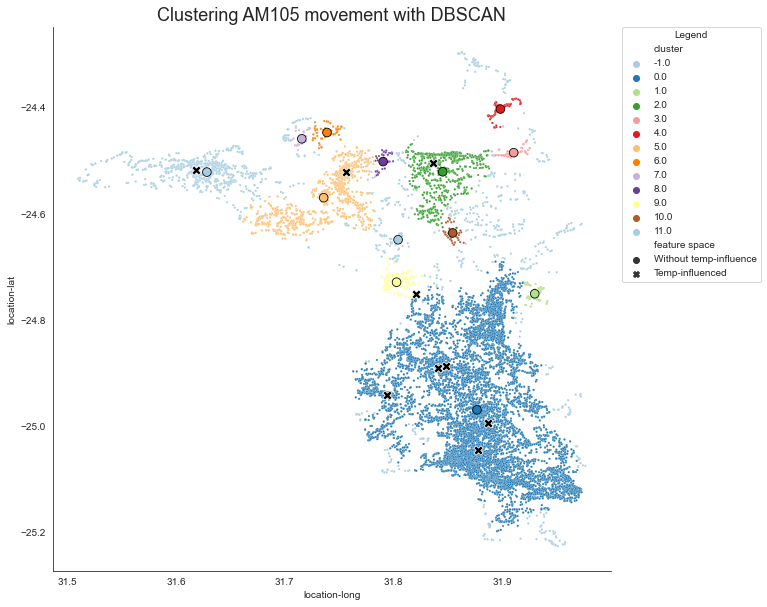

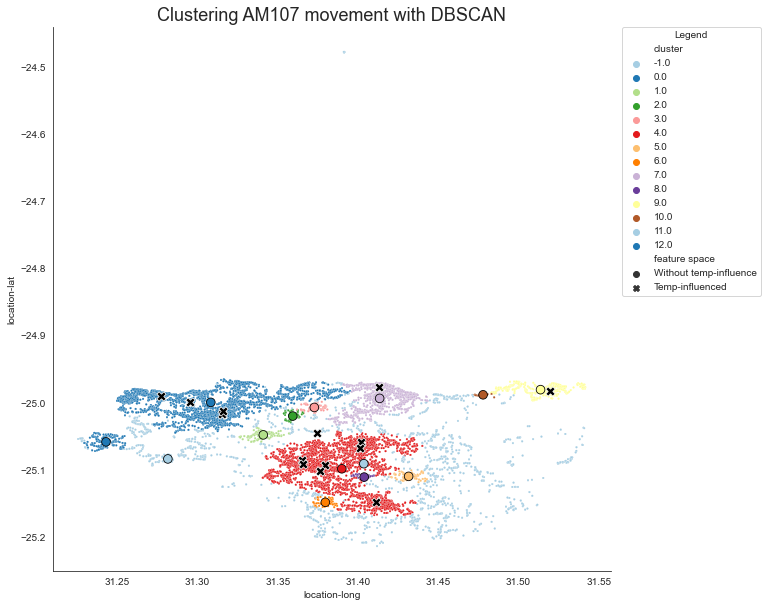

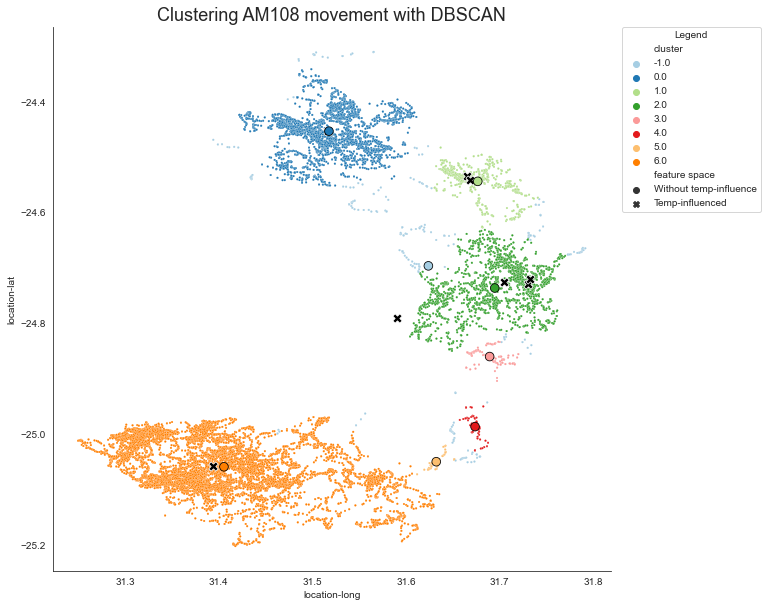

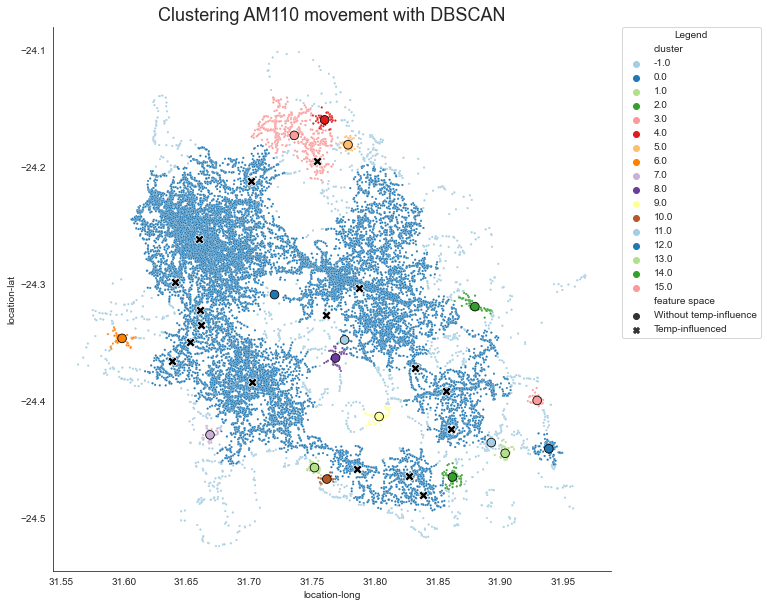

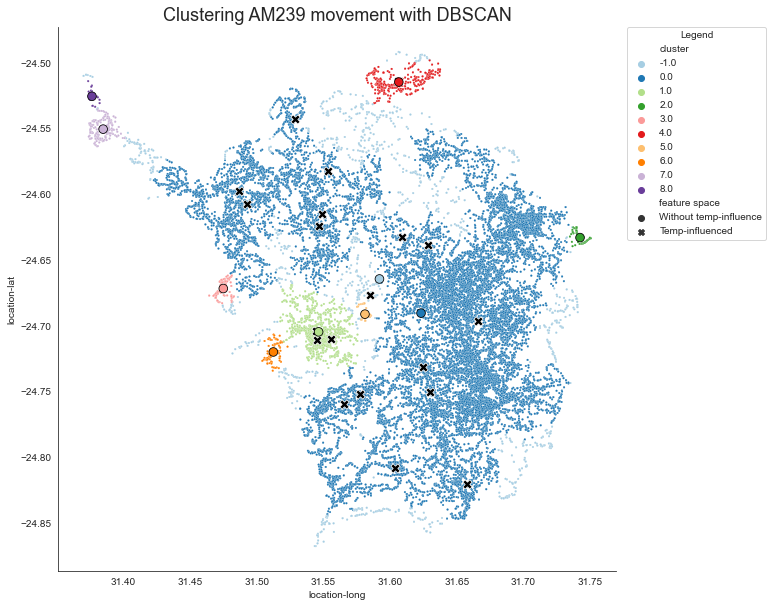

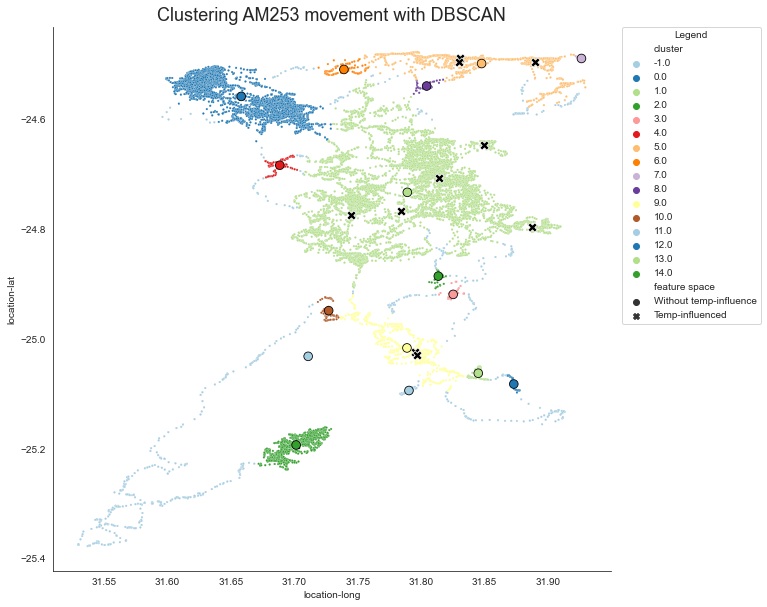

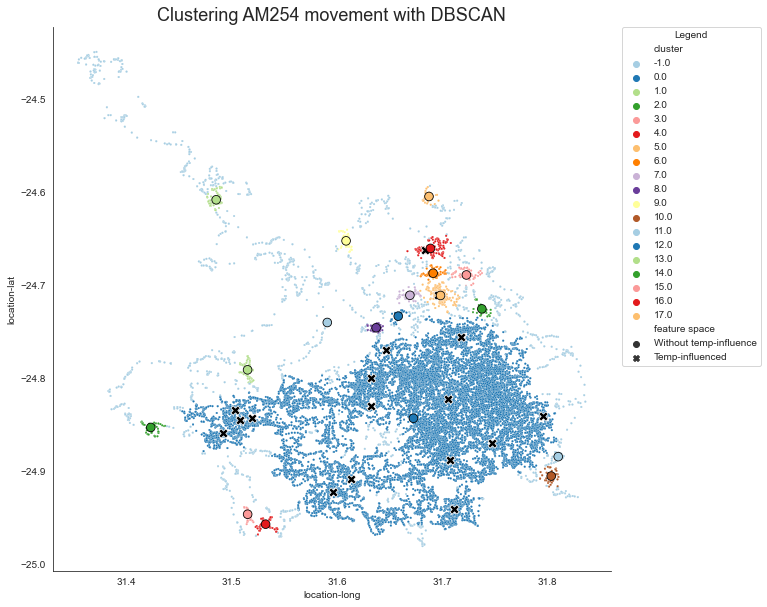

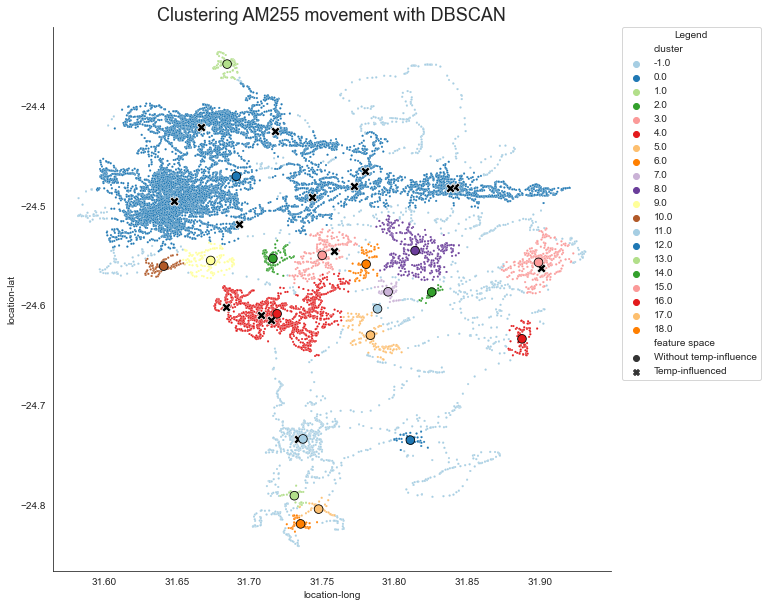

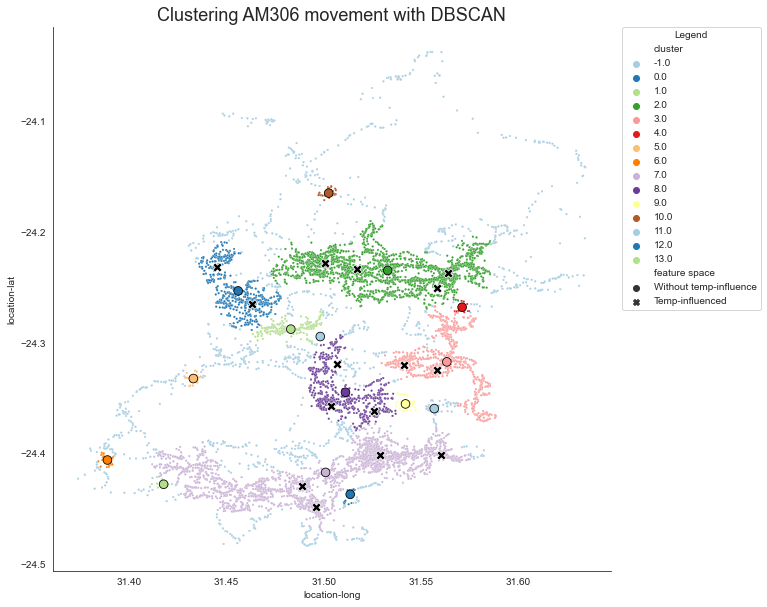

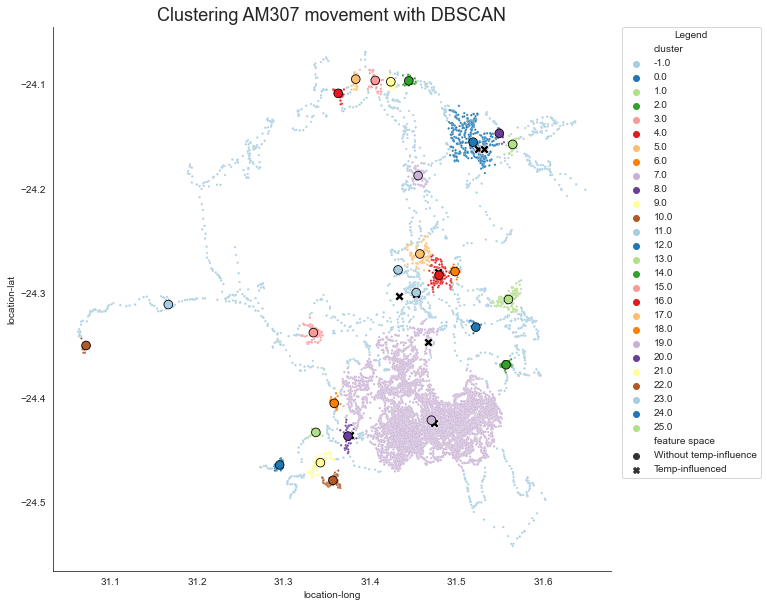

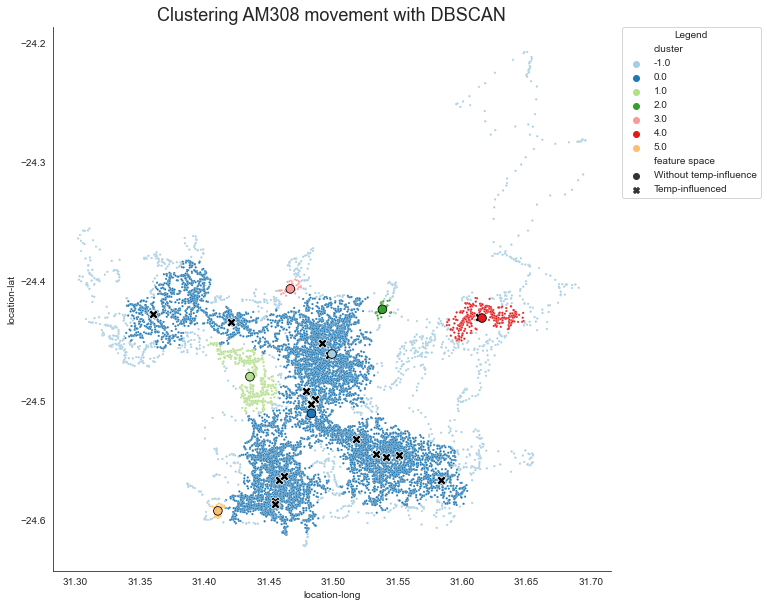

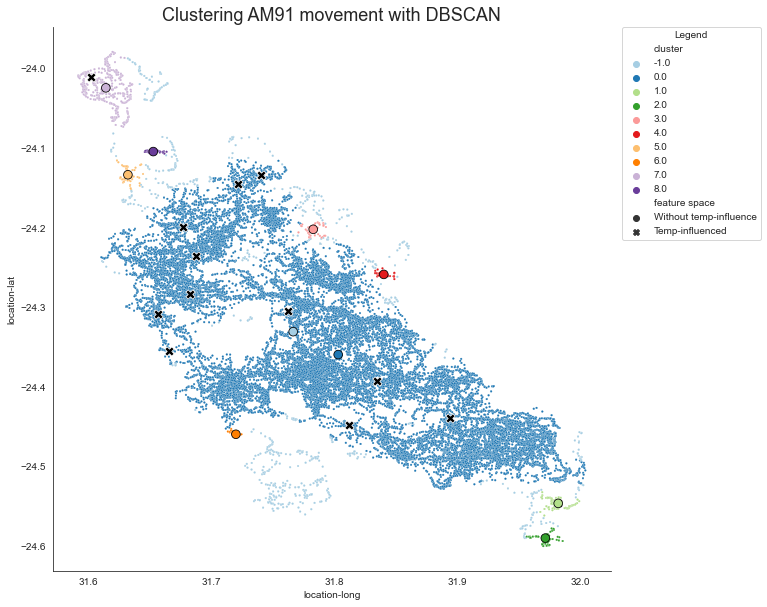

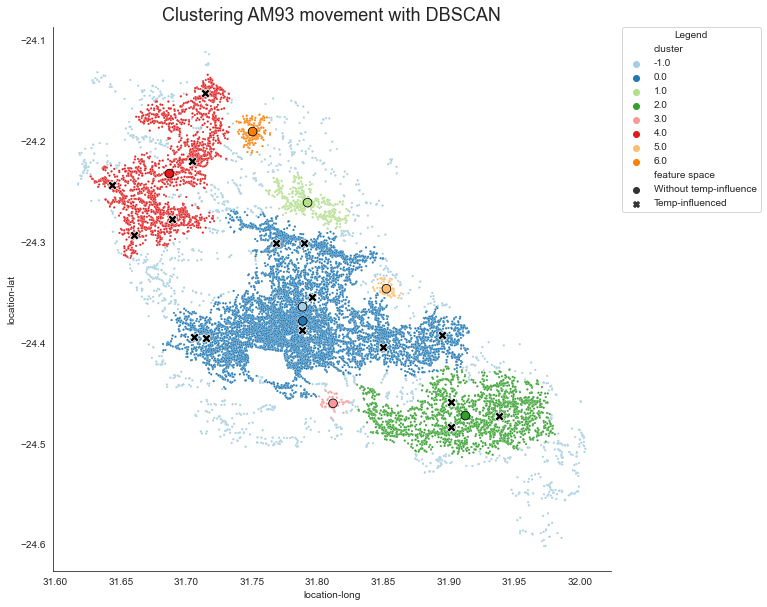

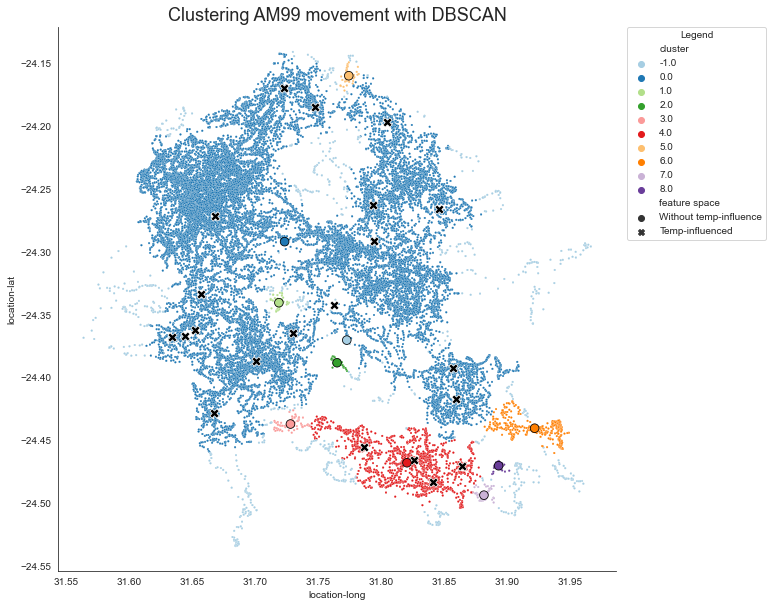

In [10]:
# Plot range clusters and centroids for each elephant
for tag, group in data.groupby("tag-local-identifier"):

    (clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(group)

    clusters = clusters_heat.append(clusters_wo)
    centroids = centroids_heat.append(centroids_wo)

    plot_range(clusters, centroids, tag)



### Combined range cluster map
This map combines all of the maps above into one map showing all of Kruger National Park. Different colors represent different elephants, with stars indicating centroids of clusters.

Processing AM105 / # clusters: 20
Processing AM107 / # clusters: 26
Processing AM108 / # clusters: 14
Processing AM110 / # clusters: 32
Processing AM239 / # clusters: 28
Processing AM253 / # clusters: 26
Processing AM254 / # clusters: 34
Processing AM255 / # clusters: 33
Processing AM306 / # clusters: 30
Processing AM307 / # clusters: 33
Processing AM308 / # clusters: 22
Processing AM91 / # clusters: 21
Processing AM93 / # clusters: 23
Processing AM99 / # clusters: 29


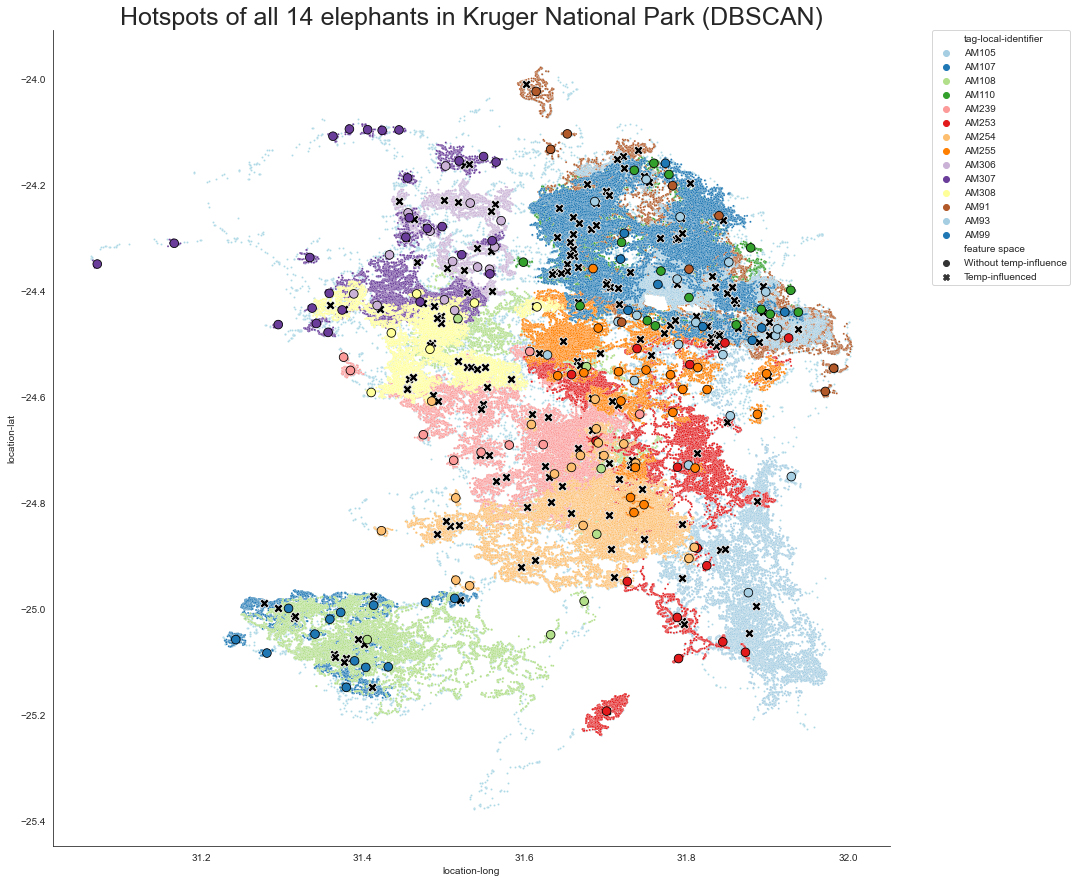

In [11]:
# options
show_centroids = True
show_clusters = True


all_centroids = pd.DataFrame()
all_clusters = pd.DataFrame()

for tag, group in data.groupby("tag-local-identifier"):
    
 
    (clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(group, noise=False)

    clusters = clusters_heat.append(clusters_wo)
    centroids = centroids_heat.append(centroids_wo)
    
    
    print(f"Processing {tag} / # clusters: {centroids.shape[0]}")
    
    centroids["tag-local-identifier"] = tag
    clusters["tag-local-identifier"] = tag
    all_centroids = all_centroids.append(centroids)
    all_clusters = all_clusters.append(clusters)


# Plotting settings
fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.set_style("white")
sns.despine()
plt.title("Hotspots of all 14 elephants in Kruger National Park (DBSCAN)", fontsize=25)


# plot sample of all data
sns.scatterplot(data = data.sample(n=100000, replace=False), 
                x="location-long", 
                y="location-lat",
                palette="Paired",
                s=4,
                legend=False,
                color="lightblue",
                ax=ax
               )

# plot clusters
if show_clusters:
    sns.scatterplot(data = all_clusters, 
                    x="location-long", 
                    y="location-lat",
                    hue="tag-local-identifier",
                    palette="Paired",
                    legend=(not show_centroids),
                    s=4,
                    ax=ax
                   ) 
    
# plot centroids
if show_centroids:
    plot_centroids(all_centroids, ax, hue="tag-local-identifier")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
all_centroids.reset_index(drop=True).to_file("Kruger_centroids.json", driver="GeoJSON")  